# Isotropic diffusion in minerals: Example from Sr in hornblende
*Jordan Lubbers*

Sr tracer-diffusion in hornblende follows an Arrhenius relationship and has been determined to be:

$$ D_{Sr} = 4.9x10^{-8}e^{\left(\frac{-260kJ}{RT}\right)}$$ 

parallel to the c axis (Brabander and Giletti, 1995). Below we will develop a model to quantify the degree of diffusion that has occured from an initial profile in hornblende using the explicit finite difference method applied to Fick's $2^{nd}$ Law. The solution for this discretization is:

$$C_{i,j+1} = C_{i,j}+D\Delta t\left[\frac{C_{i+1,j}-2C_{i,j}+C_{i-1,j}}{\Delta x^2}\right]$$ 

Numerical stability is achieved by satisfying the Courant condition:

$$ \frac{D\Delta t}{\Delta x^2} < 0.5 $$

This is preferred over the analytical solution to Fick's $2^{nd}$ Law (e.g., Crank 1975) as it offers more freedom in inital boundary conditions that are not step functions. 


# Importing data

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
import scipy.interpolate as interp
import seaborn as sns


# Create a dataframe from your uploaded file
data = pd.read_excel(
    "/Users/jordanlubbers/Desktop/PhD/Research/DATA/Toba/spreadsheets/amphibole_proc_all.xlsx"
)
grain_data = data.set_index("grain")

grainlist = list(grain_data.index.unique())
grain_dropdown = widgets.Dropdown(
    options=grainlist, value=grainlist[0], description="Grain: "
)
grain_dropdown

Dropdown(description='Grain: ', options=('MQA2', 'MQA1', 'MQA6', 'MQA7', 'MQA8', 'MQA9', 'MQA10', 'MQA11', 'MQ…

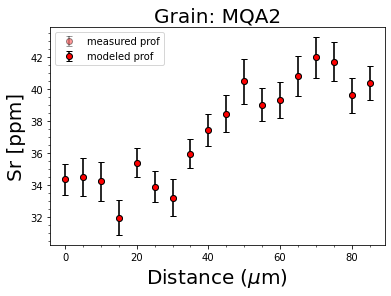

In [25]:
# Choose grain
grain = grain_dropdown.value

# choose the starting and stopping point for the part of the profile you want to use
clip_start = 0
clip_stop = 6
dist_original = grain_data.loc[grain, "distance"]
prof_length = len(dist_original)
dist_all = dist_original[clip_start : prof_length - clip_stop]


start = 0
stop = 0


# measured trace element information
te_all = grain_data.loc[grain, "Sr"][clip_start : prof_length - clip_stop]
te_unc_all = grain_data.loc[grain, "Sr_se"][clip_start : prof_length - clip_stop]


# trace element information for the model interval
te = te_all[start : len(te_all) - stop]
te_unc = te_unc_all[start : len(te_all) - stop]
dist = dist_all[start : len(te_all) - stop]


# plot observed data and initial condition
fig, ax = plt.subplots(figsize=(6, 4))
# observed profile
ax.errorbar(
    dist_all,
    te_all,
    yerr=te_unc_all,
    fmt="ro",
    mec="k",
    ecolor="k",
    capsize=3,
    alpha=0.4,
    label="measured prof",
)
ax.errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="ro",
    mec="k",
    ecolor="k",
    capsize=3,
    label="modeled prof",
)
ax.set_title("Grain: {}".format(grain), fontsize=20)
ax.legend(loc="best")
ax.set_ylabel("Sr [ppm]", fontsize=20)
ax.set_xlabel("Distance ($\mu$m)", fontsize=20)
ax.minorticks_on()

# Create random profile based on analytical error

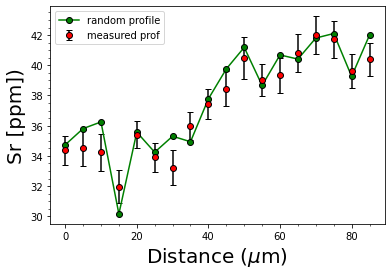

In [26]:
# random profile from your y and yerr
def random_profile(x, y, yerr):
    """random_profile generates a random observed profile for diffusion modeling that is based of the measured value 
    and its corresponding uncertainty at each point. 
            Inputs:
            x = x data 
            y = y data
            yerr = 1 sigma uncertainty on y data measurements. If your data has 2 sigma uncertainties, just 
            create a new variable that divides it by 2 so you have 1 standard deviation uncertainties
            
            Returns:
            yrand = random y data points who's liklihood is normally distributed around the mean"""
    import numpy as np

    # np.random.normal(mean,std deviation)
    yrand = np.random.normal(loc=y, scale=yerr)
    return yrand


yrand = random_profile(dist, te, te_unc)
fig, ax = plt.subplots(figsize=(6, 4))
# observed profile
ax.errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="ro",
    mec="k",
    ecolor="k",
    capsize=3,
    label="measured prof",
)
# random profile
ax.plot(dist, yrand, "-go", mec="k", label="random profile")
ax.legend(loc="best")
ax.set_ylabel("Sr [ppm])", fontsize=20)
ax.set_xlabel("Distance ($\mu$m)", fontsize=20)
ax.minorticks_on()

# Thermodynamic parameters and $D_{Sr}$

In [27]:
# Constants and calculating diffusion coefficients


def diffusivity(Do, E, T):
    """diffusivity calculates the diffusivity of an element that follows 
    basic Arrhenius relationship in the form Di = Do(e^{-E/RT}).
                Inputs:
                Do = pre-exponent factor (m^2/s)
                E = Activation energy (J/mol)
                T = Temperature (K)
                
                Returns:
                Di = Arrhenius diffusion coefficient for a given 
                element in a given mineral in um^2/s"""
    import math

    R = 8.314  # J/Kmol
    Di = (Do * math.exp(-E / (R * T))) * 1e12
    return Di


# Constants
# Temperature Kelvin
T_K = 750 + 273.15
# Celsius
T_C = T_K - 273

sinyear = 60 * 60 * 24 * 365.25

# conditions for calculating diffusivity of element in mineral
# Sr in amphibole from Brabander and Giletti 1995
Do = 4.9 * 10 ** -8
E = 260e3


# Sr diffusion in hornblende
Sr_di = diffusivity(Do, E, T_K)
t20 = (0.24 * (((5) * 1e-6) ** 2) / (Sr_di / 1e12)) / sinyear

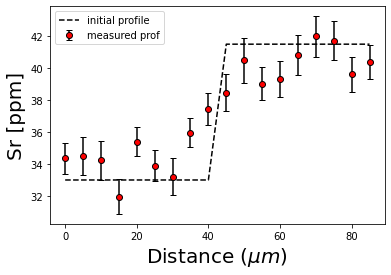

In [28]:
# this multiplies the amount of of x points you have effectively 'filling in' your x grid
multiplier = 1
# setting up your finite difference with a specified number of x points
# here we are saying to add 5 times as many interpolated points as observed points

# number of points in your xgrid
nx = len(dist) * multiplier
# creating your xgrid
x = np.linspace(np.min(dist), np.max(dist), nx)
# x spacing
dx = x[1] - x[0]
# since our Di is in um^2/s we need to factor that into our time grid
# by spacing out the points accordingly.
iterations = int(18250)
sinyear = 60 * 60 * 24 * 365.25
tenthsofyear = sinyear / 10
days = sinyear / 365.25
sinday = 60 * 60 * 24

# creating a time grid that is spaced by years
t = np.arange(0, iterations * sinyear + 1, sinyear)
dt = t[1] - t[0]
nt = len(t)


# containers for each iteration
# unknown at current iteration
u = np.zeros(nx)
# u at previous iteration
u_n = np.zeros(nx)


# initial condition as a step function
# these numbers are the actual distance in microns
# we convert them to their index in the array later
stepstart = 45 - np.min(dist)
stepstop = 2000 - np.min(dist)

# boundary conditions in ppm for left, middle, and right
Cl = 33
Cm = 41.5
Cr = 55

step_begin = stepstart
step_begin_idx = int(step_begin / dx)
step_stop = stepstop
step_stop_idx = int(step_stop / dx)

# # IF THERE ARE TWO DOUBLE SIDED STEP FUNCTIONS IN ONE PROFILE
# stepstart2 = 35 - np.min(dist)
# stepstop2 = 200 - np.min(dist)
# Cl2 = Cr
# Cm2 = 55
# Cr2 = 41


step2_begin = stepstart2
step2_begin_idx = int(step2_begin / dx)
step2_stop = stepstop2
step2_stop_idx = int(step2_stop / dx)

u_n[:step_begin_idx] = Cl
# u_n[step_begin_idx:step_stop_idx] = np.interp(x[step_begin_idx:step_stop_idx],np.array((x[step_begin_idx],x[step_stop_idx])),np.array((Cl,Cr)))
u_n[step_begin_idx:step_stop_idx] = Cm
u_n[step_stop_idx:] = Cr


# #if there are two step functions use this bit instead of the Cr
# #above
# u_n[step_stop_idx:step2_begin_idx] = Cr
# # u_n[step2_begin_idx:step2_stop_idx] = np.interp(x[step2_begin_idx:step2_stop_idx],np.array((x[step2_begin_idx],x[step2_stop_idx])),np.array((Cl2,Cr2)))
# u_n[step2_begin_idx:step2_stop_idx] = Cm2
# u_n[step2_stop_idx:] = Cr2


step_func = u_n.copy()
fig, ax = plt.subplots()

ax.errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="ro",
    mec="k",
    ecolor="k",
    capsize=3,
    label="measured prof",
)
ax.plot(x, step_func, "k--", label="initial profile")


ax.set_ylabel("Sr [ppm]", fontsize=20)
ax.set_xlabel("Distance ($\mu m$)", fontsize=20)
ax.legend(loc="best")

# Implementing the diffusion equation

In [29]:
# creating a container to put all of your curve iterations
curves = np.zeros((nt, nx))
# courant condition (this must be <.5)
# iterating over the length of nt(each iteration is a time step)
F = Sr_di * dt / dx ** 2
if F >= 0.5:
    print("You do not have numerical stability, please adjust your grid accordingly")
else:
    for n in tqdm(range(0, int(nt))):

        u[1 : nx - 1] = u_n[1 : nx - 1] + F * (
            u_n[0 : nx - 2] - 2 * u_n[1 : nx - 1] + u_n[2:nx]
        )

        u[0] = Cl  # fixing your boundary conditions with above values
        u[-1] = te[-1]
        #             u[-1] = Cr
        curves[n, :] = u  # saving your iteration to your curve container
        u_n[:] = u  # switch your variables before the next iteration
        # makes your current u vals the u_n vals in the next loop

  0%|          | 0/18251 [00:00<?, ?it/s]

# Finding the best fit
Here we will implement a basic $\chi^2$ minimization to find the best fit iteration. This quantifies the overall deviation for a given diffusion profile from the observed profile by:

$$ \chi^2 = \sum_{i=1}^{k} \frac{(O_i - E_i)^2}{E_i}$$ 

where $O_i$ is a given spot, $i$ in the diffusion model at time $j$, and $E_i$ is the observed data at that point in the distance grid.

In [30]:
chi2 = abs(
    np.sum((curves - te.to_numpy()[None, :]) ** 2 / (te.to_numpy()[None, :]), axis=1)
)
chi2_min = np.min(chi2)
fit_idx = np.argwhere(chi2 == chi2_min)
fit_idx = fit_idx[0].item()
bf_time = fit_idx + 1
bf_time

1282

# Visualize the results

Text(0.5, 0.98, 'Grain: MQA2')

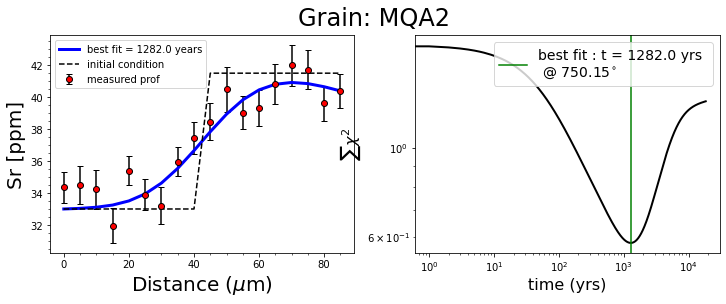

In [31]:
# make iterations to years we have to divide by 365 since we iterate in days
makeyears = 1

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="ro",
    mec="k",
    ecolor="k",
    capsize=3,
    label="measured prof",
)

ax[0].plot(
    x,
    curves[bf_time],
    "-",
    c="blue",
    label="best fit = {} years".format(np.round(bf_time / makeyears, 2)),
    lw=3,
)
ax[0].plot(x, step_func, "k--", label="initial condition")
ax[0].minorticks_on()
ax[0].legend(loc="best")
ax[0].set_ylabel("Sr [ppm]", fontsize=20)
ax[0].set_xlabel("Distance ($\mu$m)", fontsize=20)

# chi-squared plot
# convert to days
tdays = t / dt
# chi-squared curve

ax[1].plot(
    tdays / makeyears, chi2, "-k", lw=2,
)

# vertical line at best fit value
ax[1].axvline(
    bf_time / makeyears,
    color="g",
    label="best fit : t = {} yrs \n @ {}$^{{\circ}}$".format(
        np.round(bf_time / makeyears, 2), T_K - 273
    ),
)
ax[1].set_xlabel("time (yrs)", fontsize=16)
ax[1].set_ylabel("$\sum{\chi^2} $", fontsize=16)
ax[1].set_xscale("log")
ax[1].legend(loc="best", prop={"size": 14})
ax[1].set_yscale("log")
fig.suptitle("Grain: {}".format(grain), fontsize=24)

In [32]:
# function to run the monte carlo simulation
def Monte_Carlo_FD_long(n, limit):
    """
    inputs:
    n : int
    number of iterations for the monte carlo simulation
    
    limit : int
    number of iterations for each individual diffusion model
    in the monte carlo (e.g., how long should it run for?)
    
    """
    best_fits = [] * n
    x = np.linspace(np.min(dist), np.max(dist), nx)

    for i in tqdm(range(0, n)):
        u_n = step_func.copy()

        yrand = random_profile(dist, te, te_unc)
        f_rand = interp.interp1d(dist, yrand)
        rand_interp = f_rand(x)

        # creating a container to put all of your curve iterations
        curves = np.zeros((nt, nx))

        for n in range(0, int(limit)):

            u[1 : nx - 1] = u_n[1 : nx - 1] + F * (
                u_n[0 : nx - 2] - 2 * u_n[1 : nx - 1] + u_n[2:nx]
            )

            u[0] = Cl  # fixing your boundary conditions with above values
            u[-1] = te[-1]
            curves[n, :] = u  # saving your iteration to your curve container
            u_n[:] = u  # switch your variables before the next iteration
            # makes your current u vals the u_n vals in the next loop

        chi2 = abs(
            np.sum(
                (rand_interp[None, :] - curves) ** 2 / (rand_interp[None, :]), axis=1
            )
        )
        chi2_min = np.min(chi2)
        fit_idx = np.argwhere(chi2 == chi2_min)
        fit_idx = fit_idx[0].item()
        bf_time_mc = fit_idx + 1

        best_fits.append(bf_time_mc)
    #         fig,ax = plt.subplots()
    #         ax.plot(dist,yrand)
    #         ax.plot(x,step_func)
    #         ax.plot(x,curves[bf_time_mc])

    return best_fits

# Monte Carlo diffusion model 
This uses the analytical uncertainty in your profile to random profile. This random profile is constructed by generating a normally distributed random value at each point in the profile that is dictated by the mean value and it's one-sigma uncertainty. Each random profile is then run through the diffusion model outlined above and a best fit diffusion time is assigned to it. 

In [33]:
# run the monte carlo simulation a desired number of times. Put an upper limit on it.
# This is really only an issue if you have large uncertainties in your data which may cause erroneous
# profiles


limit = 1e4  # 10000 years

n = 1000

best_fits = Monte_Carlo_FD_long(n, limit)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.6, 0.4, '$T_{actual}$ = 1282.0 yrs')

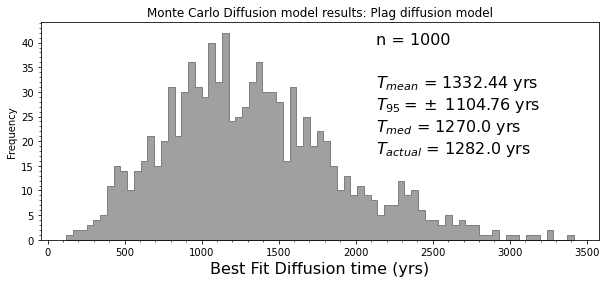

In [34]:
mc = np.array(best_fits) / makeyears
# if you need to trim some extremely erroneous tails
# mc = mc[mc< 4000]
# x = random.choice(x,size = 10)

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(mc, bins=75, kde=False, color="gray", element="step")
ax.set_title("Monte Carlo Diffusion model results: Plag diffusion model")
ax.set_xlabel("Best Fit Diffusion time (yrs)", fontsize=16)
ax.set_ylabel("Frequency")
ax.text(0.6, 0.9, "n = {}".format(len(mc)), transform=ax.transAxes, fontsize=16)
ax.text(
    0.6,
    0.7,
    "$T_{{mean}}$ = {} yrs".format(np.round(np.mean(mc), 2)),
    transform=ax.transAxes,
    fontsize=16,
)
ax.text(
    0.6,
    0.6,
    "$T_{{95}} = \pm$ {} yrs".format(np.round(1.96 * np.std(mc), 2)),
    transform=ax.transAxes,
    fontsize=16,
)
ax.text(
    0.6,
    0.5,
    "$T_{{med}}$ = {} yrs".format(np.round(np.median(mc), 2)),
    transform=ax.transAxes,
    fontsize=16,
)
# ax.set_xlim(0,8000)
ax.minorticks_on()
# this is manually input after your run the diffusion model based on the measured profile not the random
ax.text(
    0.6,
    0.4,
    "$T_{{actual}}$ = {} yrs".format(np.round(bf_time / 1, 2)),
    transform=ax.transAxes,
    fontsize=16,
)

Text(0.5, 1.1, 'Diffusion Model Uncertainty CGI: MQA2')

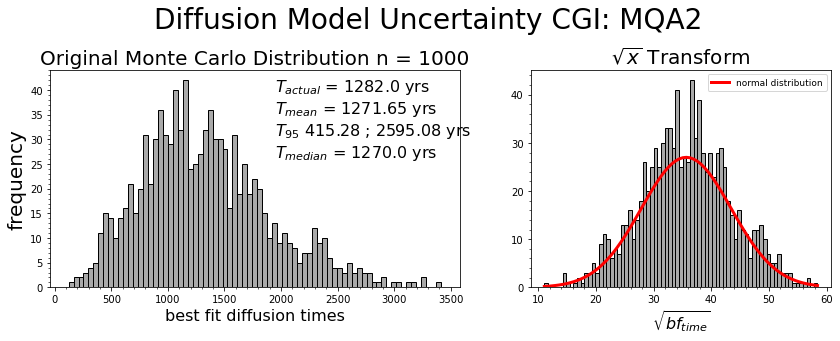

In [36]:
bin_n = 75
# Transforming your data to make it normally distributed
transform = np.sqrt(mc)
transform_std = np.std(transform)
transform_mean = np.mean(transform)
transform_median = np.median(transform)


# Back calculate mean and standard deviation
back_all = transform ** 2
back_mean = transform_mean ** 2
back_median = transform_median ** 2
back_std_l = (transform_mean - 1.96 * transform_std) ** 2
back_std_u = (transform_mean + 1.96 * transform_std) ** 2

# #Transforming your data to make it normally distributed
# transform = np.log(mc)
# transform_std = np.std(transform)
# transform_mean = np.mean(transform)
# transform_median = np.median(transform)


# #Back calculate mean and standard deviation
# back_all = np.exp(transform)
# back_mean = np.exp(transform_mean)
# back_median = np.exp(transform_median)
# back_std_l = np.exp(transform_mean - 1.96*transform_std)
# back_std_u = np.exp(transform_mean + 1.96*transform_std)


fig, ax = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={"width_ratios": [1.5, 1.1],})


h, bins, patches = ax[0].hist(back_all, bins=bin_n, color="darkgray", edgecolor="k")

# ax[0].text(.8,.9,'n = {}'.format(len(x)),transform=ax[0].transAxes,fontsize = 16)
ax[0].text(
    0.55,
    0.9,
    "$T_{{actual}}$ = {} yrs".format(np.round(bf_time / 1, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)
ax[0].text(
    0.55,
    0.8,
    "$T_{{mean}}$ = {} yrs".format(np.round(back_mean, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)
ax[0].text(
    0.55,
    0.7,
    "$T_{{95}}$ {} ; {} yrs".format(np.round(back_std_l, 2), np.round(back_std_u, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)
ax[0].text(
    0.55,
    0.6,
    "$T_{{median}}$ = {} yrs".format(np.round(back_median, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)

ax[0].set_ylabel("frequency", fontsize=20)
ax[0].set_xlabel("best fit diffusion times", fontsize=16)
ax[0].set_title("Original Monte Carlo Distribution n = {}".format(len(mc)), fontsize=20)
ax[0].minorticks_on()

# histogram for the transformed data
h2, bins2, patches2 = ax[1].hist(transform, bins=bin_n, color="darkgray", edgecolor="k")

# Goes into the height array and finds the value that is neares the transform mean
multiply = h2[
    np.where(
        np.logical_and(bins2 > 0.98 * transform_mean, bins2 < 1.0 * transform_mean)
    )
]

# multiply = 160

# create normal distribution based on your transform mean, std dev, and the bin locations as the x array
normal_dist = (1 / transform_std * np.sqrt(2 * np.pi)) * np.exp(
    -0.5 * ((bins2 - transform_mean) / transform_std) ** 2
)

# scale the normal distribution to match the height of your histogram
normal_dist_scaled = normal_dist * multiply / np.max(normal_dist)


ax[1].plot(bins2, normal_dist_scaled, c="r", lw=3, label="normal distribution")
ax[1].set_xlabel("$\sqrt{bf_{time}}$", fontsize=16)

ax[1].minorticks_on()
ax[1].set_title("$\sqrt{x}$ Transform", fontsize=20)


# ax[1].set_title('$\log{x}$ Transform',fontsize = 20)
# ax[1].set_xlabel('$\log{bf_{time}}$',fontsize = 16)


ax[1].legend(loc="upper right", fontsize=9)
fig.suptitle("Diffusion Model Uncertainty CGI: {}".format(grain), y=1.1, fontsize=28)